# Notebook 1: predicting missing values for activity

## Section 1: Loading event log

In [1]:
# installing prerequisites
!pip install pm4py


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stringdist: filename=StringDist-1.0.9-cp38-cp38-linux_x86_64.whl size=24936 sha256=9cecff8bcdbe58e79b43f4558455a49fce3d8f5eb84096f2262350f16a071977
  Stored in directory: /root/.cache/pip/wheels/7a/64/e2/16f6a25a62a78f951c1715adb24ba2271ae9d7872f42378c3a
Successfully built stringdist


In [2]:
from google.colab import auth
auth.authenticate_user()

In [3]:
from google.cloud import bigquery
client = bigquery.Client(project='processmining-367815')

In [4]:
# this is the query that will be used when generating event log,
# when generating new event logs, this is the only thing that will be changed
query = ('''
-- Events: Admitted, Discharged, Entered ICU, Left ICU,

SELECT DISTINCT
  admissions.HADM_ID AS patient,
  "Admitted" AS activity,
  string(admissions.ADMITTIME) AS timestamp
  FROM 
    physionet-data.mimiciii_clinical.admissions,
    physionet-data.mimiciii_clinical.diagnoses_icd
  WHERE 
    -- admissions.admittime IS NOT NULL AND
    diagnoses_icd.HADM_ID = admissions.HADM_ID
    AND diagnoses_icd.icd9_code BETWEEN '390%' AND '460%'
  
UNION ALL

SELECT DISTINCT
  admissions.HADM_ID AS patient,
  "Discharged" AS activity,
  string(admissions.DISCHTIME) AS timestamp
  FROM 
    physionet-data.mimiciii_clinical.admissions,
    physionet-data.mimiciii_clinical.diagnoses_icd
  WHERE 
    -- admissions.DISCHTIME IS NOT NULL AND
    diagnoses_icd.HADM_ID = admissions.HADM_ID
    AND diagnoses_icd.icd9_code BETWEEN '390%' AND '460%'

UNION ALL 

SELECT DISTINCT
  icustays.HADM_ID AS patient,
  "Entered ICU" AS activity,
  string(icustays.INTIME) AS timestamp
  FROM 
    physionet-data.mimiciii_clinical.icustays,
    physionet-data.mimiciii_clinical.diagnoses_icd
  WHERE 
    -- icustays.INTIME IS NOT NULL AND
    diagnoses_icd.HADM_ID = icustays.HADM_ID
    AND diagnoses_icd.icd9_code BETWEEN '390%' AND '460%'

UNION ALL

SELECT DISTINCT
  icustays.HADM_ID AS patient,
  "Left ICU" AS activity,
  string(icustays.OUTTIME) AS timestamp
  FROM
    physionet-data.mimiciii_clinical.icustays,
    physionet-data.mimiciii_clinical.diagnoses_icd
  WHERE 
    -- icustays.INTIME IS NOT NULL AND
    diagnoses_icd.HADM_ID = icustays.HADM_ID
    AND diagnoses_icd.icd9_code BETWEEN '390%' AND '460%'

''')

In [5]:
import pandas as pd

# loading event log from bigQuery
event_log = client.query(query).to_dataframe()
event_log["timestamp"] = pd.to_datetime(event_log["timestamp"])
event_log.sort_values(by=['patient'])
# event_log.info()

,patient,activity,timestamp
84155,100001,Discharged,2117-09-17 16:45:00
172025,100001,Left ICU,2117-09-15 17:57:14
26434,100001,Admitted,2117-09-11 11:46:00
126870,100001,Entered ICU,2117-09-11 11:47:35
13798,100003,Admitted,2150-04-17 15:34:00
...,...,...,...
10764,199998,Admitted,2119-02-18 16:26:00
29808,199999,Admitted,2136-04-04 23:37:00
120950,199999,Entered ICU,2136-04-06 16:01:10
56980,199999,Discharged,2136-04-10 12:10:00


## Section 2: process mining

In [6]:
import pm4py as pm

event_log = pm.format_dataframe(event_log, case_id='patient', activity_key='activity', timestamp_key='timestamp')
# lets get some information about the event log
n_events = len(event_log)
n_cases = len(event_log.patient.unique())
start_events = pm.get_start_activities(event_log)
end_events = pm.get_end_activities(event_log)
print(f"Number of cases: {n_cases}\nNumber of events: {n_events}")
print(f"Start events: {start_events}\nEnd events: {end_events}")


<ipython-input-6-aedec179434f>:3: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  event_log = pm.format_dataframe(event_log, case_id='patient', activity_key='activity', timestamp_key='timestamp')
/usr/local/lib/python3.8/dist-packages/pm4py/utils.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[constants.CASE_CONCEPT_NAME] = df[constants.CASE_CONCEPT_NAME].astype("string")
/usr/local/lib/python3.8/dist-packages/pm4py/utils.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

Number of cases: 42652
Number of events: 175612
Start events: {'Admitted': 42162, 'Entered ICU': 434, 'Discharged': 56}
End events: {'Discharged': 34700, 'Left ICU': 7947, 'Admitted': 5}


In [14]:
# lets improve the event log by filtering out the cases that do not start or end with a patient being admitted or discharged
# this will simplify the model

# most cases start with a person being admitted to the hospital
# interestingly, there are two cases were someone was discharged at first, these two cases might be anomalous. 
# lets first filter by these two cases:
event_log = pm.filter_start_activities(event_log, ['Admitted'])
event_log = pm.filter_end_activities(event_log,['Discharged'])
# event traces are as follows:
# discharged --> admitted --> transfer --> entered ICU --> Left ICU --> Dead



In [15]:
net, initial_marking, final_marking = pm.discover_petri_net_alpha(event_log)

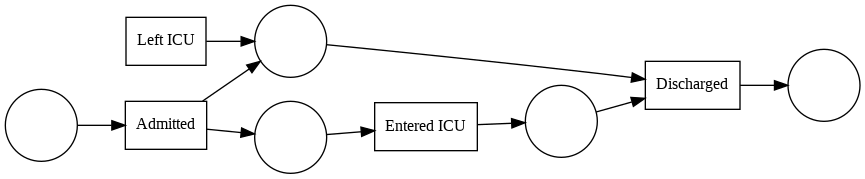

In [16]:
import graphviz
pm.view_petri_net(petri_net=net)

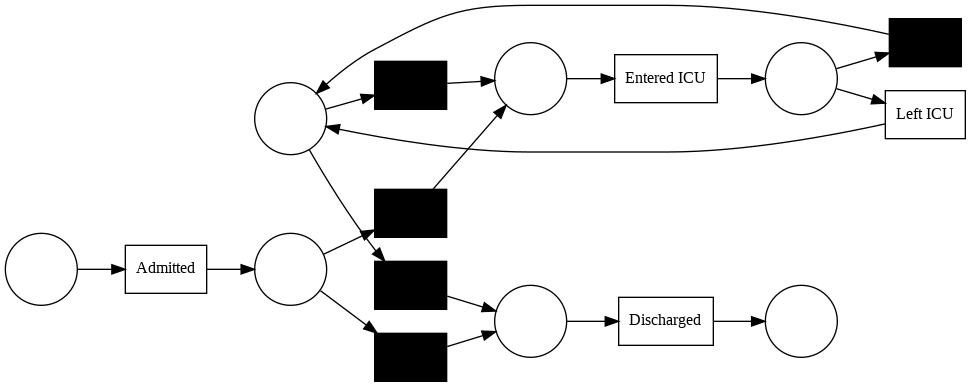

In [17]:
# inductive miner
# much better result than when using alpha miner, petri net 
net, initial_marking, final_marking = pm.discover_petri_net_inductive(event_log)
pm.view_petri_net(petri_net=net)

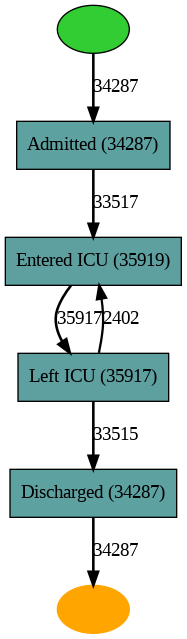

In [18]:
# heuristic miner
heu_net = pm.discover_heuristics_net(event_log, dependency_threshold=0.99)
pm.view_heuristics_net(heu_net)

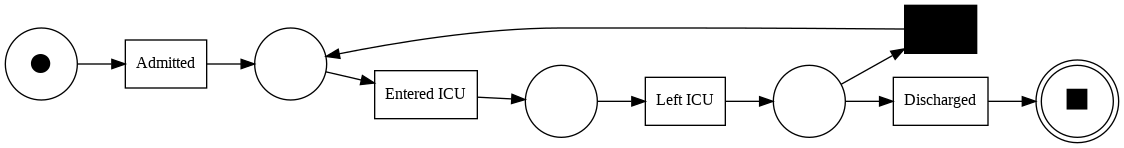

In [19]:
# petri net from heuristics miner
net, im, fm = pm.discover_petri_net_heuristics(event_log, dependency_threshold=0.99)
pm.view_petri_net(net, im, fm)

## Section 3: